In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from keras.models import Model

from sklearn.metrics import roc_auc_score

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [4]:
word2vec = {}
with open(os.path.join('glove', 'glove.6B', 'glove.6B.100d.txt'), encoding="utf-8") as f :
    for line in f :
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype=np.float32)
        word2vec[word] = vec
print(f'Found {len(word2vec)} word vectors.')

Found 400000 word vectors.


In [5]:
train_df = pd.read_csv(os.path.join('data', 'toxic_comments', 'train.csv'))
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [16]:
sentences = train_df['comment_text'].values

In [8]:
possible_labels = train_df.columns[2:].values

In [9]:
targets = train_df[possible_labels].values

In [11]:
print(f'Max sequence length {max(len(s) for s in sentences)}')
print(f'Min sequence length {min(len(s) for s in sentences)}')
s = sorted(len(s) for s in sentences)
print(f'Median sequence length {s[len(s) // 2]}')

Max sequence length 8
Min sequence length 8
Median sequence length 8


In [18]:
tokenizer = Tokenizer(oov_token='<OOV>', num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [19]:
word2idx = tokenizer.word_index
print(f'Found {len(word2idx)} unique tokens.')

Found 210338 unique tokens.


In [20]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(f'Shape of data tensor : {data.shape}')

Shape of data tensor : (159571, 100)


In [21]:
#preparing embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1) #keras word indexes start from 1, therefore last index will be 20000 instead of 19999
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items() :
    if i < MAX_VOCAB_SIZE :
        embedding_vector = word2idx.get(word)
        if embedding_vector is not None :
            #words not found will be all zeros
            embedding_matrix[i] = embedding_vector

In [22]:
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [26]:
i = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(i)
x = Conv1D(128, 3, activation='relu') (x)
x = MaxPooling1D(3) (x)
x = Conv1D(128, 3, activation='relu') (x)
x = MaxPooling1D(3) (x)
x = Conv1D(128, 3, activation='relu') (x)
x = GlobalMaxPooling1D() (x)
x = Dense(128, activation='relu') (x)
output = Dense(len(possible_labels), activation='sigmoid') (x)

model = Model(i, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 98, 128)           38528     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 32, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 30, 128)           49280     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 10, 128)          0         
 1D)                                                         

In [27]:
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [28]:
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Epoch 1/10
998/998 [==============================] - 45s 14ms/step - loss: 3.5838 - accuracy: 0.8684 - val_loss: 0.1388 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 14s 14ms/step - loss: 0.1384 - accuracy: 0.9942 - val_loss: 0.1383 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 14s 14ms/step - loss: 0.1383 - accuracy: 0.9942 - val_loss: 0.1378 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 14s 14ms/step - loss: 0.1382 - accuracy: 0.9942 - val_loss: 0.1380 - val_accuracy: 0.9941
Epoch 5/10
998/998 [==============================] - 17s 17ms/step - loss: 0.1382 - accuracy: 0.9942 - val_loss: 0.1378 - val_accuracy: 0.9941
Epoch 6/10
998/998 [==============================] - 15s 15ms/step - loss: 0.1381 - accuracy: 0.9942 - val_loss: 0.1393 - val_accuracy: 0.9941
Epoch 7/10
998/998 [==============================] - 15s 15ms/step - loss: 0.1380 - accuracy: 0.9942 - val_loss: 0.1377 - val_accuracy:

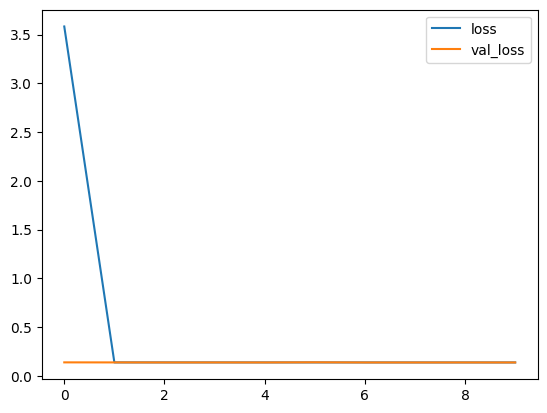

In [29]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

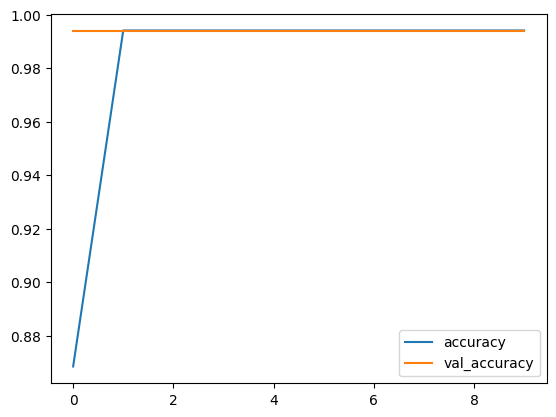

In [31]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [33]:
p = model.predict(data)
aucs= []
for j in range(6) :
    auc = roc_auc_score(targets[:, j], p[:, j])
    aucs.append(auc)
print(np.mean(aucs))

4987/4987 [==============================] - 17s 3ms/step
0.6283935830169657
